In [0]:
from pylab import *
from scipy import fft
import matplotlib.pyplot as plt
from scipy.signal import periodogram as psd
import numpy as np
from scipy.signal import find_peaks
from math import sqrt, sin
from cmath import pi
%matplotlib inline

Motorized stage details (https://www.thorlabs.com/newgrouppage9.cfm?objectgroup_id=2163): 


*   Max Velocity = 2.6 mm/s
*   Max Travel Range = 12mm (12e3 µm)
*   Minimum Step Size = 0.10 µm

*   inv step size: 10000 Hz (= $\frac{max velocity}{step size}$)

Review this document for understanding of how FTS works/ data looks: https://chem.libretexts.org/Bookshelves/Physical_and_Theoretical_Chemistry_Textbook_Maps/Supplemental_Modules_(Physical_and_Theoretical_Chemistry)/Spectroscopy/Fundamentals_of_Spectroscopy/The_Power_of_the_Fourier_Transform_for_Spectroscopists

### Want to compare different signals on the order of our expected magnitude: 

*   Source off (noise on the order of 2e-8  W)
*   Source on (blackbody spectrum with noise on the order of 1e-7W)

In [0]:
#This code, as borrowed from the Power Law Relationship file calcualtes the power (W)  of blackbody spectrum for a given frequncy 
#fixed variables
k_B = 8.617333262145e-5 #eV K^{-1}
h = 4.135667696e-15 #eV * s
c = 299792458 #m / s
eV_to_J = 1.602176565e-19 
Temp = 2000 #K

#modifiable variables
r_rad_small = 0.001 #m -radius of radiator
r_abs = 0.001 #m -radius of absorber
d =  0.1 #m -distance between absorber and radiator ?

#a is lower lim, b is upper lim, n is number of slices
def simpson(g, a, b, n): 
    h=(b-a)/n
    k=0.0
    x=a + h
    for i in arange(1,n/2 + 1):
        k += 4*g(x)
        x += 2*h
    x = a + 2*h
    for i in arange(1,n/2):
        k += 2*g(x)
        x += 2*h
    r = (h/3)*(g(a)+g(b)+k)
    return r
def gamma_0(T, r_rad):  
    area = pi * r_abs**2
    sin_theta = r_rad /np.sqrt(r_rad**2 + d**2)
    return area*sin_theta * (8 * pi * (k_B * T)**2)/(h**3 * c**2)

#function to integrate via Sumpson's rule
#Noah's modifications to be overflow safe
def power_integral(x):
    #if we have a list, convert to numpy array
    if(type(x)==list):
        x = np.array(dtype=np.float128)
        
    #if we have a numpy array, proceed
    if(type(x)== np.ndarray):
        retvals = np.zeros_like(x,dtype=np.float128)
        inds = x < 1e3
        #small values can be directly calculated
        retvals[inds] = x[inds]**3/(np.exp(x[inds])-1.0)
        #in the limit of large x, f(x)~exp(-x)
        retvals[~inds] = np.exp(-x[~inds])
        return retvals
    
    #assume we have a number
    else: 
        if(type(x)!='float128'):
            x=np.float128(x)
        if(x>1e3):
            return np.exp(-x)
        else:
            return x**3/(np.exp(x)-1.0)

#this function returns power, given bounds in terms of energy
def power_func(T, a, b, r_rad):
    start = a/(k_B * T)  #lowerbound
    end = b/(k_B * T) #upperbound
    n = 100 #slices
    return eV_to_J * k_B**2 * T**2 * gamma_0(T, r_rad)*simpson(power_integral,start,end,n)
def power_intensity(v, slice_size):
    E_min = (v-slice_size)*h #eV 
    E_max = (v+slice_size)*h #eV 
    #print("e = " , v*h, " & E_min =", E_min," & E_max =", E_max )
    power = power_func(Temp, E_min, E_max, r_rad_small)
    return power

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:71: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:80: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:89: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

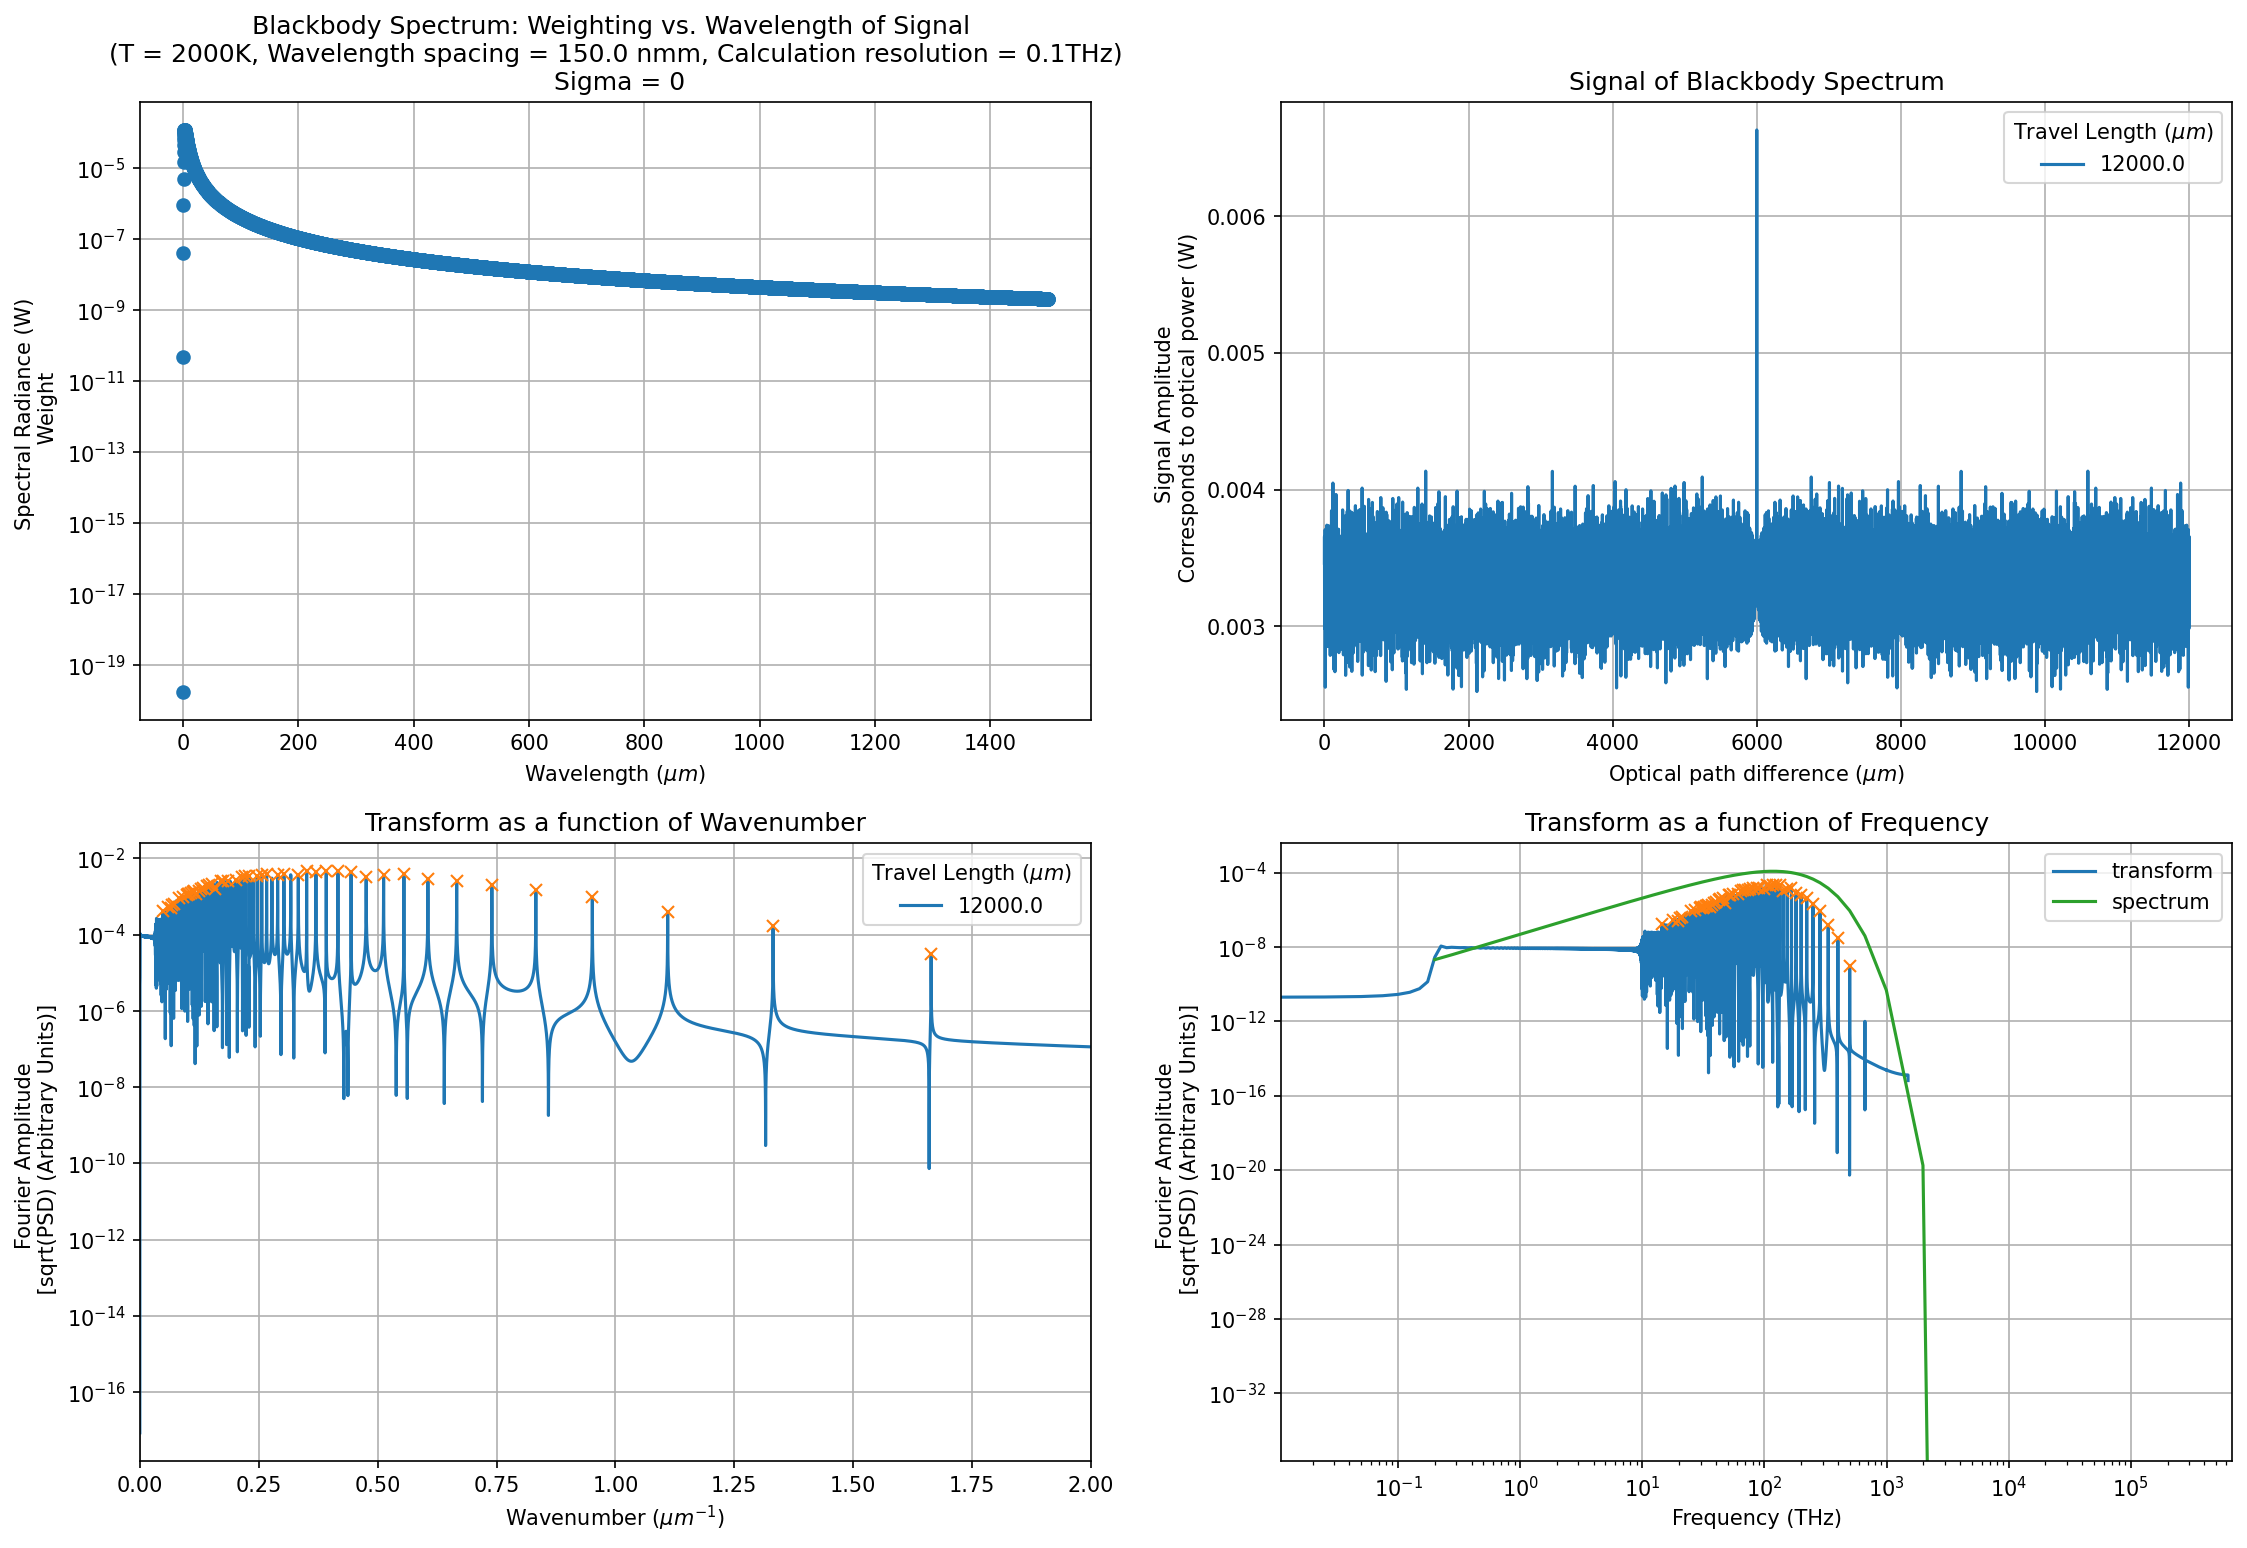

For total travel distance  12000.0 µm the peaks occur at frequencies: [ 14.6    17.7    19.6    20.2    21.275  25.     27.025  29.85   30.3
  31.25   32.25   33.325  33.9    34.475  35.7    37.025  38.45   40.
  42.55   43.475  45.45   47.6    51.275  52.625  55.55   60.6    64.5
  66.65   68.95   74.05   76.9    79.975  86.925  90.875  99.975 105.225
 111.075 117.6   124.95  133.275 142.8   153.775 166.575 181.7   199.875
 222.05  249.8   285.45  332.975 399.475 499.175] THz
There are  51  measured peaks


In [0]:
arm_length_1 = 15 #cm
arm_length_2 = 10 #cm
cm_to_micron = 10000

mm_to_micron = 1000
dx = -6*mm_to_micron #abs(arm_length_1-arm_length_2)*cm_to_micron

random_phase = False
adjustment = 1e-7


dt = 0.1 #micron, step size
fs = 1/dt #micron^-1, inv. step size (multiply by h gives energy resolution)
Tlist = [12e3] #micron, total travel length
sigma = 0 #2e-6  #noise offset intensity
peaks = []
weights_nofilter = []
c_micron_per_second = 3e8 * 1e6
Hz_to_THz = 1e-12
peak_thershold = 1e-6 #increase this as noise increases, to ensure we are not accidnetally claiming the noise as a peak

fig = plt.figure(figsize=(18, 12), dpi=150)  

#for blackbody spectrum, decide wavelength range and number of wavelength slices (should correspond to the number of peaks in that window after transform)
min_wavelength = 0.001 #micron
max_wavelength = 1500 #micron
num_slices = 10000 #1e6
wavelength_slice_size = (max_wavelength - min_wavelength)/num_slices #micron
wavelengths = arange(min_wavelength, max_wavelength, wavelength_slice_size)
freq_slice_size = 0.1e+12 #c_micron_per_second/wavelength_slice_size  #2THz slice size for integration window 

for lam in wavelengths: #(microns)
  freq = c_micron_per_second/lam #converts wavelength in micron to Hz frequency 
  weights_nofilter.append(power_intensity(freq, freq_slice_size)) # for blackbody, this is the blackbody intensity in W
plt.subplot(2, 2, 1)
plt.plot(wavelengths, weights_nofilter , 'o')

for T in Tlist:
  x=np.arange(0,T,dt)
  y_phaseNoise = np.zeros_like(x)
  for lam in range(len(wavelengths)):
    k = 1/wavelengths[lam]
    phase = 2*pi*dx*k
    y_phaseNoise += weights_nofilter[lam]*(np.cos(2*pi*k*x +  phase)/2.0 + 0.5)
  y = y_phaseNoise + np.random.rand(len(x))*sigma

  
  plt.subplot(2, 2, 2)
  plt.plot(x,y,label= T)

  plt.subplot(2, 2, 3)
  f_nofilter,p_nofilter = psd(y,fs=fs) #frequency, spectrum
  plt.semilogy(f_nofilter, np.sqrt(p_nofilter), label=T)
  peaks_index, _ = find_peaks(np.log10(np.sqrt(p_nofilter)), prominence=(2.3))
  plt.plot(f_nofilter[peaks_index], np.sqrt(p_nofilter[peaks_index]), "x")
  peaks.append(f_nofilter[peaks_index])

  p_adjusted_nofilter = np.sqrt(p_nofilter) - adjustment
  for ps in range(len(p_adjusted_nofilter)):
    if p_adjusted_nofilter[ps] < 0:
      p_adjusted_nofilter[ps] = 0

  plt.subplot(2, 2, 4)
  plt.semilogy(f_nofilter*c_micron_per_second*Hz_to_THz, np.sqrt(p_nofilter),label='transform')
  if T ==12e3:
    plt.plot(f_nofilter[peaks_index]*c_micron_per_second*Hz_to_THz, np.sqrt(p_nofilter[peaks_index]), "x")

#plot details for blackbody spectrum plot
plt.subplot(2, 2, 1)
plt.grid(True)
plt.yscale('log')
title = "Blackbody Spectrum: Weighting vs. Wavelength of Signal \n (T = " + str(Temp) + "K, Wavelength spacing = "+ str(round(wavelength_slice_size*1000,2)) + " nmm, Calculation resolution = " + str(round(freq_slice_size/1e12, 2)) + "THz) \n Sigma = " + str(sigma)
plt.title(title)
plt.xlabel("Wavelength ($\mu m$)")
plt.ylabel("Spectral Radiance (W) \n Weight")

#plot details for signal plot
plt.subplot(2, 2, 2)
plt.grid(True)
plt.title("Signal of Blackbody Spectrum")
plt.legend(title="Travel Length ($\mu m$)")
plt.legend(title="Travel Length ($\mu m$)")
plt.xlabel("Optical path difference ($\mu m$)")
plt.ylabel("Signal Amplitude \n Corresponds to optical power (W)")

#plot details for fourier transform plot
plt.subplot(2, 2, 3)
plt.title("Transform as a function of Wavenumber")
plt.xlim(0, 2)
#plt.ylim(1e-10, 1e-1)
plt.grid(True)
plt.legend(title="Travel Length ($\mu m$)")
plt.xlabel('Wavenumber ($\mu m ^{-1}$)')
plt.ylabel("Fourier Amplitude \n [sqrt(PSD) (Arbitrary Units)]")

#plot details for fourier transform plot in terms of frequency rather than wavenumber
plt.subplot(2, 2, 4)
plt.semilogy(c_micron_per_second*Hz_to_THz/wavelengths, weights_nofilter, label = 'spectrum')
plt.title("Transform as a function of Frequency")
#plt.xlim(0,50)
plt.xscale('log')
plt.grid(True)
plt.legend()
plt.xlabel('Frequency (THz)')
plt.ylabel("Fourier Amplitude \n [sqrt(PSD) (Arbitrary Units)]")
plt.show()

print("For total travel distance ", Tlist[0], "µm the peaks occur at frequencies:", peaks[0]*c_micron_per_second*Hz_to_THz , "THz")
print("There are ", len(peaks[0]), " measured peaks")


## Adding the Si Filter:

Gentec Electro-Optics silicon window 1.1 – 9 ; 50 – 1000μm 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:65: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:75: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: MatplotlibDeprecationWarnin

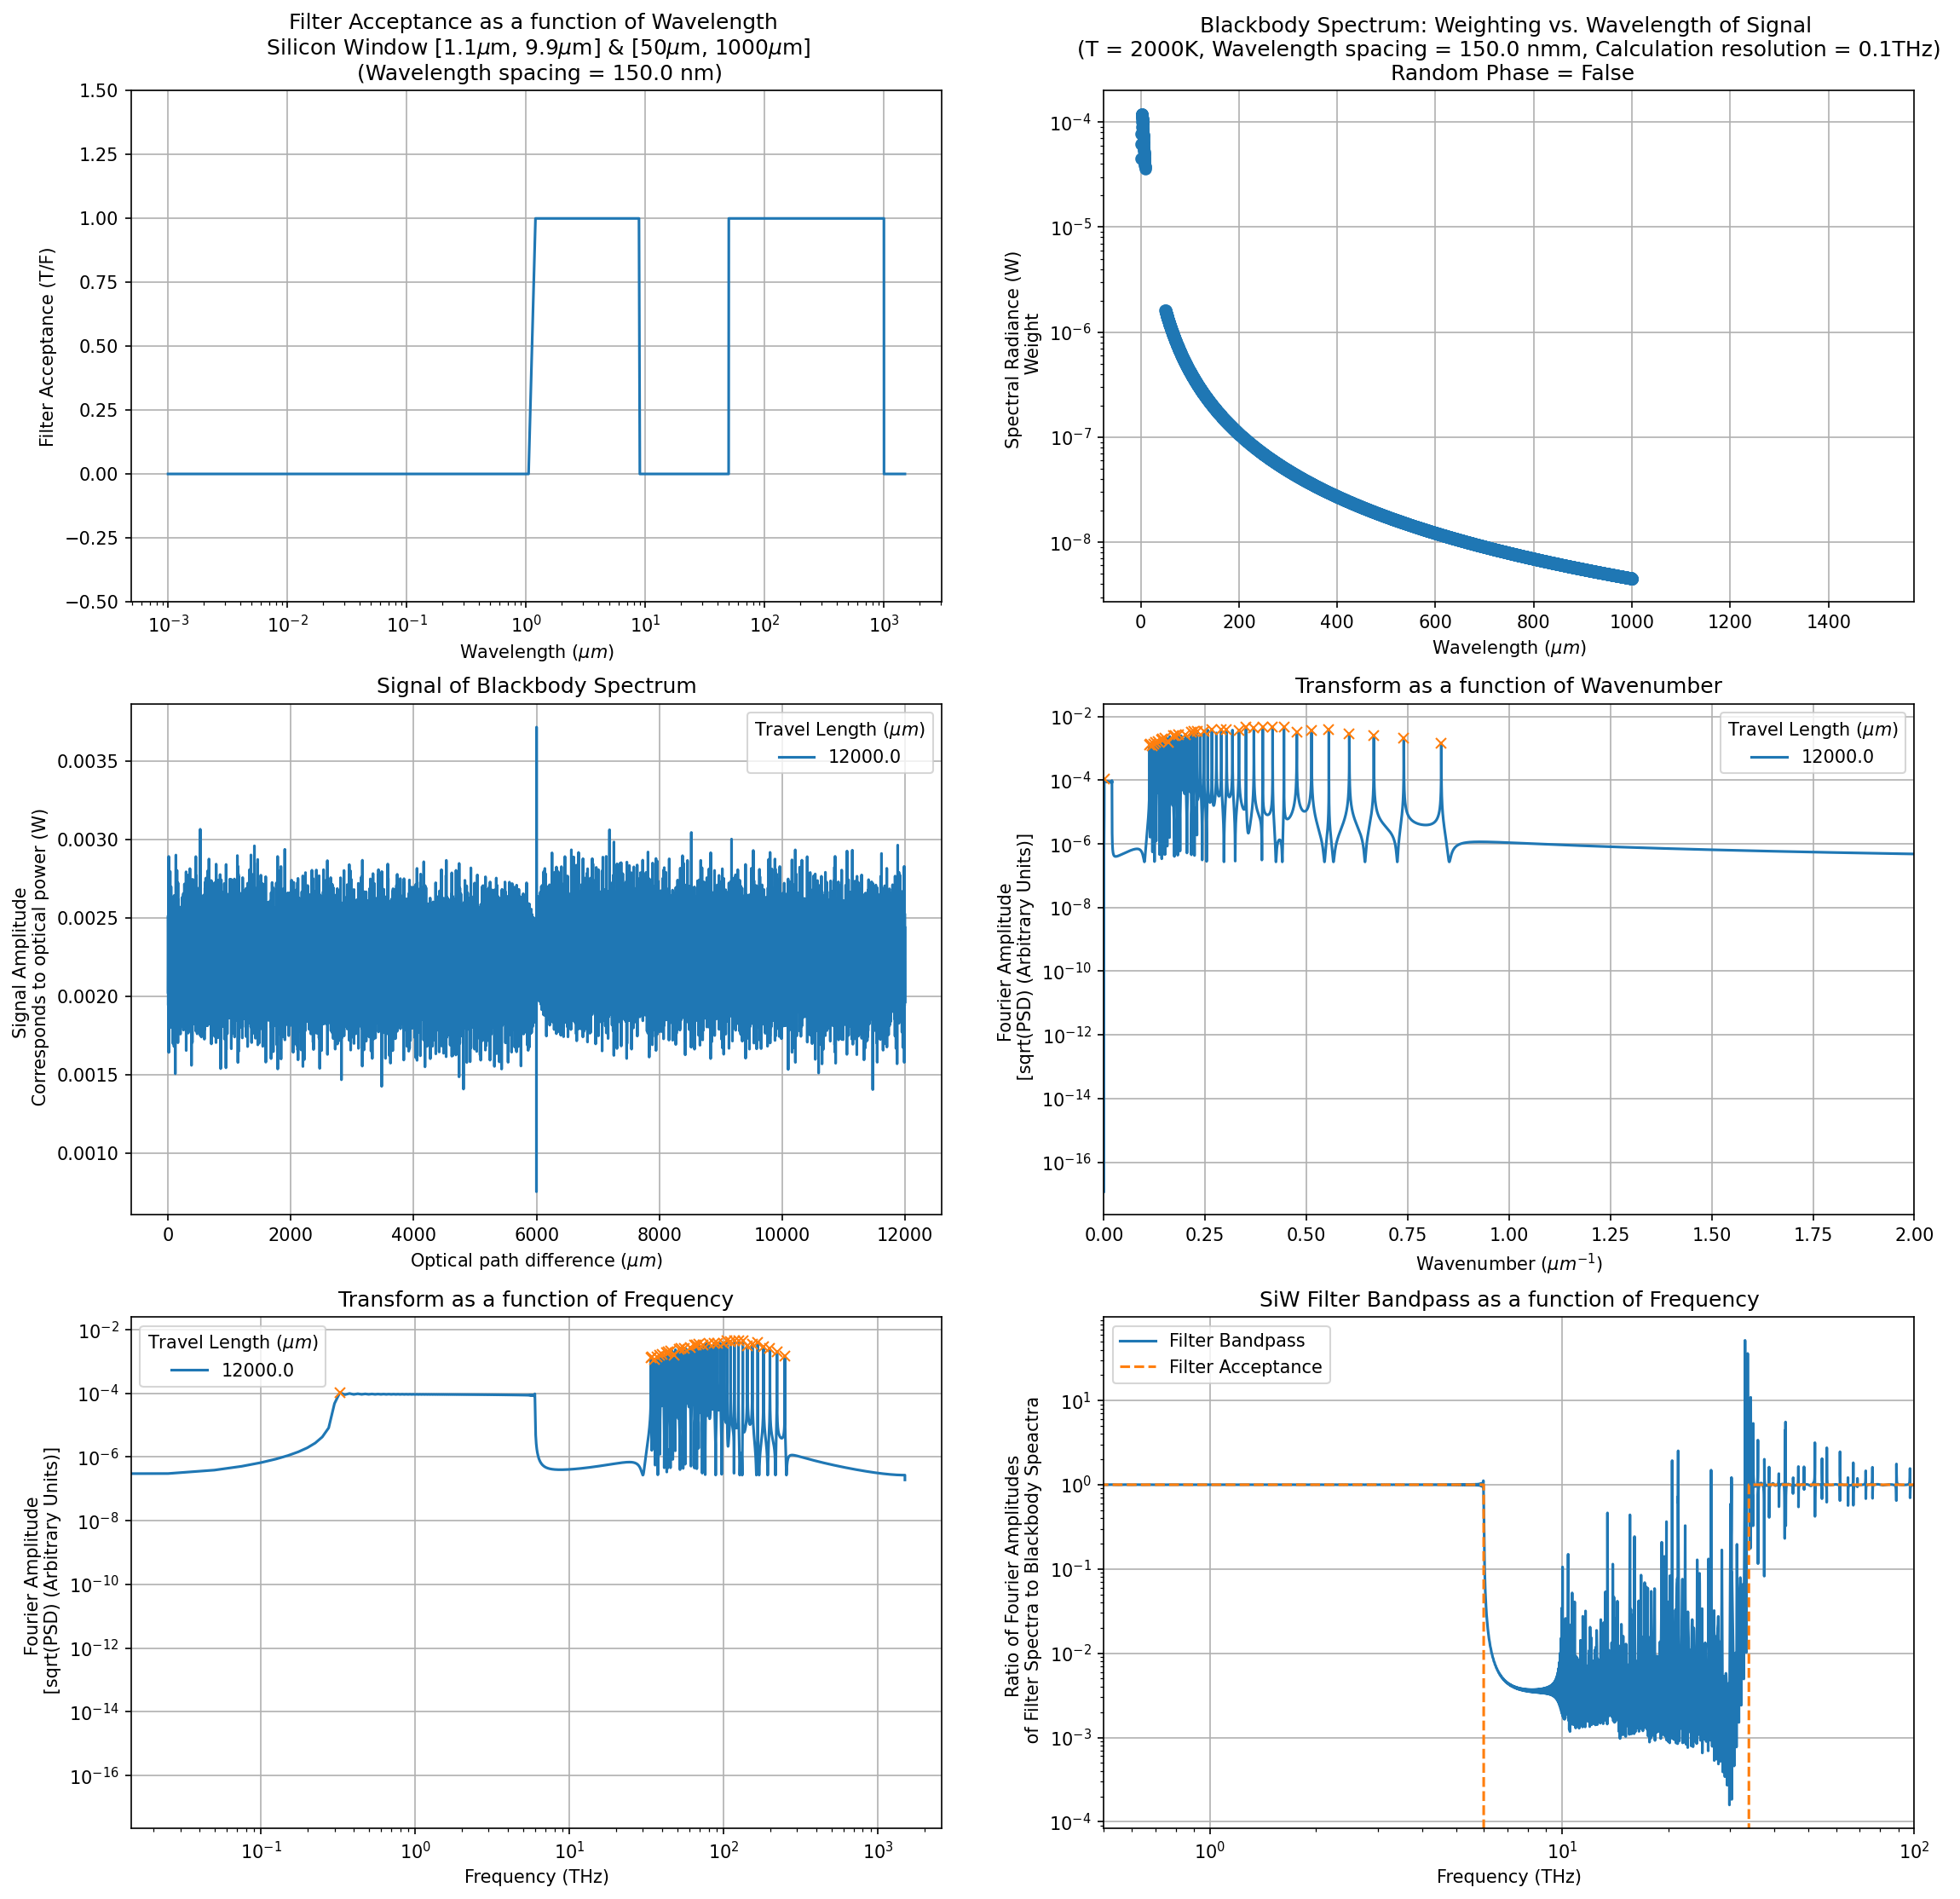

For total travel distance  12000.0 µm the peaks occur at frequencies: [  0.325  33.9    34.475  35.7    37.025  38.45   40.     42.55   43.475
  45.45   47.6    51.275  52.625  55.55   60.6    64.5    66.65   68.95
  74.05   79.975  86.925  90.875  99.975 105.225 111.075 117.6   124.95
 133.275 142.8   153.775 166.575 181.7   199.875 222.05  249.8  ] THz
There are  35  measured peaks


In [0]:
#There are two different on segments for this filter
filter_range_1 = [1.1, 9] #micron
filter_range_2 = [50, 1000] #micron
filter_val = [] #just a function to hold on / off values for the filter to be able to show the top hat representation 


peaks = []
weights = []


fig = plt.figure(figsize=(18, 18), dpi=150)  
for lam in range(len(wavelengths)): #(microns)
  if min(filter_range_1) <= wavelengths[lam] <= max(filter_range_1) or min(filter_range_2) <= wavelengths[lam] <= max(filter_range_2):
    weights.append(weights_nofilter[lam]) # for blackbody, this is the blackbody intensity in W
    filter_val.append(1)
  else:
    weights.append(0)
    filter_val.append(0)

plt.subplot(3, 2, 1)
plt.plot(wavelengths, filter_val)

plt.subplot(3, 2, 2)
plt.plot(wavelengths, weights , 'o')

for T in Tlist:
  x=np.arange(0,T,dt)
  #yNoNoise = np.zeros_like(x)
  y_phaseNoise = np.zeros_like(x)
  for lam in range(len(wavelengths)):
    k = 1/wavelengths[lam]
    if random_phase:
      randPhase = np.random.uniform()*2*pi
    else:
      randPhase = 0
    phase = 2*pi*dx*k
    y_phaseNoise += weights[lam]*(np.sin(2*pi*k*x + randPhase + phase)/2.0 + 0.5)
  y = y_phaseNoise + np.random.rand(len(x))*sigma
  
  plt.subplot(3, 2, 3)
  plt.plot(x,y,label= T)

  plt.subplot(3, 2, 4)
  f,p = psd(y,fs=fs) #frequency, spectrum
  plt.semilogy(f, np.sqrt(p), label=T)

  p_adjusted = np.sqrt(p) - adjustment
  for ps in range(len(p_adjusted)):
    if p_adjusted[ps] < 0:
      p_adjusted[ps] = 0

  peaks_index, _ = find_peaks(np.log10(np.sqrt(p)), prominence=(2.3))
  plt.plot(f[peaks_index], np.sqrt(p[peaks_index]), "x")
  peaks.append(f[peaks_index])

  plt.subplot(3, 2, 5)
  plt.semilogy(f*c_micron_per_second*Hz_to_THz, np.sqrt(p),label=T)
  if T ==12e3:
    plt.plot(f[peaks_index]*c_micron_per_second*Hz_to_THz, np.sqrt(p[peaks_index]), "x")

plt.subplot(3,2,6)
plt.semilogy(f*c_micron_per_second*Hz_to_THz, p_adjusted/p_adjusted_nofilter, label = "Filter Bandpass")
plt.semilogy(c_micron_per_second*Hz_to_THz/wavelengths, filter_val, '--', label = 'Filter Acceptance')

#plot details for filter plot
plt.subplot(3, 2, 1)
plt.grid(True)
plt.ylim(-0.5, 1.5)
plt.xscale('log')
title = "Filter Acceptance as a function of Wavelength \n Silicon Window [1.1$\mu$m, 9.9$\mu$m] & [50$\mu$m, 1000$\mu$m] \n (Wavelength spacing = "+ str(round(wavelength_slice_size*1000,2)) + " nm)"
plt.title(title)
plt.xlabel("Wavelength ($\mu m$)")
plt.ylabel("Filter Acceptance (T/F)")

#plot details for blackbody spectrum plot
plt.subplot(3, 2, 2)
plt.grid(True)
plt.yscale('log')
title = "Blackbody Spectrum: Weighting vs. Wavelength of Signal \n (T = " + str(Temp) + "K, Wavelength spacing = "+ str(round(wavelength_slice_size*1000,2)) + " nmm, Calculation resolution = " + str(round(freq_slice_size/1e12, 2)) + "THz) \n Random Phase = " + str(random_phase) 
plt.title(title)
plt.xlabel("Wavelength ($\mu m$)")
plt.ylabel("Spectral Radiance (W) \n Weight")

#plot details for signal plot
plt.subplot(3, 2, 3)
plt.grid(True)
plt.title("Signal of Blackbody Spectrum")
plt.legend(title="Travel Length ($\mu m$)")
plt.xlabel("Optical path difference ($\mu m$)")
plt.ylabel("Signal Amplitude \n Corresponds to optical power (W)")

#plot details for fourier transform plot
plt.subplot(3, 2, 4)
plt.title("Transform as a function of Wavenumber")
plt.legend(title="Travel Length ($\mu m$)")
plt.xlim(0, 2)
plt.grid(True)
plt.xlabel('Wavenumber ($\mu m ^{-1}$)')
plt.ylabel("Fourier Amplitude \n [sqrt(PSD) (Arbitrary Units)]")

#plot details for fourier transform plot in terms of frequency rather than wavenumber
plt.subplot(3, 2, 5)
plt.title("Transform as a function of Frequency")
plt.legend(title="Travel Length ($\mu m$)")
plt.xscale('log')
plt.grid(True)
plt.xlabel('Frequency (THz)')
plt.ylabel("Fourier Amplitude \n [sqrt(PSD) (Arbitrary Units)]")

#plot details for transfer function (which is power specctrum in frequency for filter/ blackbody~ like dividing out the noise) 
plt.subplot(3, 2, 6)
plt.title("SiW Filter Bandpass as a function of Frequency")
plt.xscale('log')
plt.grid(True)
plt.legend()
plt.xlim(5e-1, 100)
plt.xlabel('Frequency (THz)')
plt.ylabel("Ratio of Fourier Amplitudes \n of Filter Spectra to Blackbody Speactra")
plt.show()

print("For total travel distance ", Tlist[0], "µm the peaks occur at frequencies:", peaks[0]*c_micron_per_second*Hz_to_THz , "THz")
print("There are ", len(peaks[0]), " measured peaks")

## Adding the PEW Filter:

Gentec Electro-Optics polyethelene window 10 – 1000μm 

In [0]:
#filter range for the PEW filter
filter_range = [10, 1000] #micron
filter_val = [] #just a function to hold on / off values for the filter to be able to show the top hat representation 

peaks = []
weights = []
fig = plt.figure(figsize=(18, 18), dpi=150)  

for lam in range(len(wavelengths)): #(microns)
  if min(filter_range) <= wavelengths[lam] <= max(filter_range):
    weights.append(weights_nofilter[lam]) # for blackbody, this is the blackbody intensity in W
    filter_val.append(1)
  else:
    weights.append(0)
    filter_val.append(0)

plt.subplot(3, 2, 1)
plt.plot(wavelengths, filter_val)
   
plt.subplot(3, 2, 2)
plt.plot(wavelengths, weights , 'o')

for T in Tlist:
  x=np.arange(0,T,dt)
  #yNoNoise = np.zeros_like(x)
  y_phaseNoise = np.zeros_like(x)
  for lam in range(len(wavelengths)):
    k = 1/wavelengths[lam]
    if random_phase:
      randPhase = np.random.uniform()*2*pi
    else:
      randPhase = 0
    phase = 2*pi*dx*k
    y_phaseNoise += weights[lam]*(np.sin(2*pi*k*x + randPhase + phase)/2.0 + 0.5)
  y = y_phaseNoise + np.random.rand(len(x))*sigma
  
  plt.subplot(3, 2, 3)
  plt.plot(x,y,label= T)

  plt.subplot(3, 2, 4)
  f,p = psd(y,fs=fs) #frequency, spectrum
  plt.semilogy(f, np.sqrt(p), label=T)
  peaks_index, _ = find_peaks(np.log10(np.sqrt(p)), prominence=(2.3))
  plt.plot(f[peaks_index], np.sqrt(p[peaks_index]), "x")
  peaks.append(f[peaks_index])

  p_adjusted = np.sqrt(p) - adjustment
  for ps in range(len(p_adjusted)):
    if p_adjusted[ps] < 0:
      p_adjusted[ps] = 0

  plt.subplot(3, 2, 5)
  plt.semilogy(f*c_micron_per_second*Hz_to_THz, np.sqrt(p),label=T)
  if T ==12e3:
    plt.plot(f[peaks_index]*c_micron_per_second*Hz_to_THz, np.sqrt(p[peaks_index]), "x")

plt.subplot(3, 2, 6)
plt.semilogy(f*c_micron_per_second*Hz_to_THz, p_adjusted/p_adjusted_nofilter, label = 'Filter Bandpass' )
plt.semilogy(c_micron_per_second*Hz_to_THz/wavelengths, filter_val, '--', label = 'Filter Acceptance')

#plot details for filter plot
plt.subplot(3, 2, 1)
plt.grid(True)
plt.ylim(-0.5, 1.5)
plt.xscale('log')
title = "Filter Acceptance as a function of Wavelength \n Polyethelene Window [10$\mu$m, 1000$\mu$m] \n (Wavelength spacing = "+ str(round(wavelength_slice_size*1000,2)) + " nm)"
plt.title(title)
plt.xlabel("Wavelength ($\mu m$)")
plt.ylabel("Filter Acceptance (T/F)")

#plot details for blackbody spectrum plot
plt.subplot(3, 2, 2)
plt.grid(True)
plt.yscale('log')
title = "Blackbody Spectrum: Weighting vs. Wavelength of Signal \n (T = " + str(Temp) + "K, Wavelength spacing = "+ str(round(wavelength_slice_size*1000,2)) + " nmm, Calculation resolution = " + str(round(freq_slice_size/1e12, 2)) + "THz) \n Random Phase = " + str(random_phase) 
plt.title(title)
plt.legend(title="Travel Length ($\mu m$)")
plt.xlabel("Wavelength ($\mu m$)")
plt.ylabel("Spectral Radiance (W) \n Weight")

#plot details for signal plot
plt.subplot(3, 2, 3)
plt.grid(True)
plt.title("Signal of Blackbody Spectrum")
plt.legend(title="Travel Length ($\mu m$)")
plt.xlabel("Optical path difference ($\mu m$)")
plt.ylabel("Signal Amplitude \n Corresponds to optical power (W)")

#plot details for fourier transform plot
plt.subplot(3, 2, 4)
plt.title("Transform as a function of Wavenumber")
plt.legend(title="Travel Length ($\mu m$)")
plt.xlim(0, 2)
#plt.ylim(1e-10, 1e-1)
plt.grid(True)
plt.xlabel('Wavenumber ($\mu m ^{-1}$)')
plt.ylabel("Fourier Amplitude \n [sqrt(PSD) (Arbitrary Units)]")

#plot details for fourier transform plot in terms of frequency rather than wavenumber
plt.subplot(3, 2, 5)
plt.title("Transform as a function of Frequency")
plt.legend(title="Travel Length ($\mu m$)")
#plt.xlim(0,50)
plt.xscale('log')
plt.grid(True)
plt.xlabel('Frequency (THz)')
plt.ylabel("Fourier Amplitude \n [sqrt(PSD) (Arbitrary Units)]")


#plot details for transfer function (which is power specctrum in frequency for filter/ blackbody~ like dividing out the noise) 
plt.subplot(3, 2, 6)
plt.title("PEW Filter Bandpass as a function of Frequency")
plt.xscale('log')
plt.grid(True)
plt.legend()
plt.xlim(5e-1, 100)
plt.xlabel('Frequency (THz)')
plt.ylabel("Ratio of Fourier Amplitudes \n of Filter Spectra to Blackbody Speactra")
plt.show()

print("For total travel distance ", Tlist[0], "µm the peaks occur at frequencies:", peaks[0]*c_micron_per_second*Hz_to_THz , "THz")
print("There are ", len(peaks[0]), " measured peaks")

Make filter bandpass plot comparing different values of certain variables 


*   wavelength slice size (150nm, 1500nm)
*   frequency slice size (1THz, 0.01Thz) 



In [0]:
def get_bandpass(wavelength_slices, freq_slice_size, filter_type):
  dt = 0.1 #micron, step size
  fs = 1/dt #micron^-1, inv. step size (multiply by h gives energy resolution)
  T = 12e3 #micron, total travel length
  sigma = 0 #2e-8  #noise offset intensity
  peaks = []
  c_micron_per_second = 3e8 * 1e6
  Hz_to_THz = 1e-12

  arm_length_1 = 15 #cm
  arm_length_2 = 10 #cm
  cm_to_micron = 10000

  random_phase = False
  adjustment = 1e-7
  
  #for blackbody spectrum, decide wavelength range and number of wavelength slices (should correspond to the number of peaks in that window after transform)
  min_wavelength = 0.001 #micron
  max_wavelength = 1500 #micron
  wavelength_slice_size = (max_wavelength - min_wavelength)/wavelength_slices #micron
  wavelengths = arange(min_wavelength, max_wavelength, wavelength_slice_size)

  #There are two different on segments for the SiW filter
  filter_range_1 = [1.1, 9] #micron
  filter_range_2 = [50, 1000] #micron

  #Filter range for the PEW filter
  filter_range = [10, 1000] #micron
  filter_val = [] #just a function to hold on / off values for the filter to be able to show the top hat representation

  weights_nofilter = []
  weights = []

  for lam in wavelengths: #(microns)
    freq = c_micron_per_second/lam #converts wavelength in micron to Hz frequency 
    weights_nofilter.append(power_intensity(freq, freq_slice_size)) # for blackbody, this is the blackbody intensity in W

  x=np.arange(0,T,dt)
  y_phaseNoise = np.zeros_like(x)
  y_phaseNoise_nofilter = np.zeros_like(x)

  for lam in range(len(wavelengths)):
    k = 1/wavelengths[lam]

    if filter_type == 'SiW': #filter type is SiW then determine if we are inside the range so we want 
      if min(filter_range_1) <= wavelengths[lam] <= max(filter_range_1) or min(filter_range_2) <= wavelengths[lam] <= max(filter_range_2):
        weights.append(weights_nofilter[lam]) # for blackbody, this is the blackbody intensity in W
        filter_val.append(1)
      else:
        weights.append(0)
        filter_val.append(0)

    else: #filter type is PEW
      if min(filter_range) <= wavelengths[lam] <= max(filter_range):
        weights.append(weights_nofilter[lam]) # for blackbody, this is the blackbody intensity in W
        filter_val.append(1)
      else:
        weights.append(0)
        filter_val.append(0)

    if random_phase:
      randPhase = np.random.uniform()*2*pi
    else:
      randPhase = 0

    phase = 2*pi*dx*k
    y_phaseNoise_nofilter += weights_nofilter[lam]*(np.sin(2*pi*k*x + randPhase + phase)/2.0 + 0.5)
    y_phaseNoise += weights[lam]*(np.sin(2*pi*k*x + randPhase + phase)/2.0 + 0.5)
  y_nofilter = y_phaseNoise_nofilter + np.random.rand(len(x))*sigma
  y = y_phaseNoise + np.random.rand(len(x))*sigma

  f_nofilter,p_nofilter = psd(y_nofilter,fs=fs) #frequency, spectrum
  f,p = psd(y,fs=fs) #frequency, spectrum

  p_adjusted_nofilter = np.sqrt(p_nofilter) - adjustment
  p_adjusted = np.sqrt(p) - adjustment
  for ps in range(len(p_adjusted_nofilter)):
    if p_adjusted_nofilter[ps] < 0:
      p_adjusted_nofilter[ps] = 0
    if p_adjusted[ps] < 0:
      p_adjusted[ps] = 0
  
  return(wavelength_slice_size, f*c_micron_per_second*Hz_to_THz,  p_adjusted/p_adjusted_nofilter, c_micron_per_second*Hz_to_THz/wavelengths, filter_val)

In [0]:
fig = plt.figure(figsize=(8, 8), dpi=150)  
wavlength_slices_numbers = [1e3, 1e4, 1e5]
for i in range(len(wavlength_slices_numbers)):
  wavelength_slice_size, freq, ratio, filter_frequancies, filter_values = get_bandpass(wavlength_slices_numbers[i], 0.1e12, 'SiW') #(wavelength_slices, freq_slice_size, filter_type)
  plt.semilogy(freq, ratio, label = "Filter Bandpass, $\lambda$ slice size = "+ str(round(wavelength_slice_size*1000,2)) + "nm")

plt.semilogy(filter_frequancies, filter_values, '--', label = 'Filter Acceptance')
plt.title("SiW Filter Bandpass as a function of Frequency for varying wavelength slice sizes")
plt.grid(True)
plt.legend()
plt.xlim(5e-1, 100)
plt.xlabel('Frequency (THz)')
plt.ylabel("Ratio of Fourier Amplitudes \n of Filter Spectra to Blackbody Speactra")
plt.xscale('log')
plt.show()

In [0]:
fig = plt.figure(figsize=(8, 8), dpi=150)  
frequency_integration_resolution = [0.01e12, 0.1e12, 1e12 ]
for i in range(len(frequency_integration_resolution)):
  wavelength_slice_size, freq, ratio, filter_frequancies, filter_values = get_bandpass(1e5, frequency_integration_resolution[i], 'SiW') #(wavelength_slices, freq_slice_size, filter_type)
  plt.semilogy(freq, ratio, label = "Filter Bandpass, ν slice size = "+ str(round(frequency_integration_resolution[i]/1e12,2)) + "THz")

plt.semilogy(filter_frequancies, filter_values, '--', label = 'Filter Acceptance')
plt.title("SiW Filter Bandpass as a function of Frequency for varying integration resolution")
plt.grid(True)
plt.legend()
plt.xlim(5e-1, 100)
plt.xlabel('Frequency (THz)')
plt.ylabel("Ratio of Fourier Amplitudes \n of Filter Spectra to Blackbody Speactra")
plt.xscale('log')
plt.show()

In [0]:
fig = plt.figure(figsize=(8, 8), dpi=150)  
wavlength_slices_numbers = [1e3, 1e4, 1e5]
for i in range(len(wavlength_slices_numbers)):
  wavelength_slice_size, freq, ratio, filter_frequancies, filter_values = get_bandpass(wavlength_slices_numbers[i], 0.1e12, 'PEW') #(wavelength_slices, freq_slice_size, filter_type)
  plt.semilogy(freq, ratio, label = "Filter Bandpass, $\lambda$ slice size = "+ str(round(wavelength_slice_size*1000,2)) + "nm")

plt.semilogy(filter_frequancies, filter_values, '--', label = 'Filter Acceptance')
plt.title("PEW Filter Bandpass as a function of Frequency for varying wavelength slice sizes")
plt.grid(True)
plt.legend()
plt.xlim(5e-1, 100)
plt.xlabel('Frequency (THz)')
plt.ylabel("Ratio of Fourier Amplitudes \n of Filter Spectra to Blackbody Speactra")
plt.xscale('log')
plt.show()

In [0]:
fig = plt.figure(figsize=(8, 8), dpi=150)  
frequency_integration_resolution = [0.01e12, 0.1e12, 1e12 ]
for i in range(len(frequency_integration_resolution)):
  wavelength_slice_size, freq, ratio, filter_frequancies, filter_values = get_bandpass(1e5, frequency_integration_resolution[i], 'PEW') #(wavelength_slices, freq_slice_size, filter_type)
  plt.semilogy(freq, ratio, label = "Filter Bandpass, ν slice size = "+ str(round(frequency_integration_resolution[i]/1e12,2)) + "THz")

plt.semilogy(filter_frequancies, filter_values, '--', label = 'Filter Acceptance')
plt.title("PEW Filter Bandpass as a function of Frequency for varying integration resolution")
plt.grid(True)
plt.legend()
plt.xlim(5e-1, 100)
plt.xlabel('Frequency (THz)')
plt.ylabel("Ratio of Fourier Amplitudes \n of Filter Spectra to Blackbody Speactra")
plt.xscale('log')
plt.show()